In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

# plt.rcParams["figure.figsize"] = (11, 11)

In [68]:
ORB = cv.ORB_create(nfeatures=2000, WTA_K=4)
MATCHER = cv.BFMatcher_create(cv.NORM_HAMMING2)

def compute_and_filter_keypoint_descriptors(img, keypoints_xloc_restrictions=None):
    keypoints_not_filtered, descriptors_not_filtered = ORB.detectAndCompute(img, None)

    if keypoints_xloc_restrictions is not None:
        x, less_or_greater = keypoints_xloc_restrictions
        valid_keypoints_idxs = []
        if less_or_greater == '<':
            for i, kp in enumerate(keypoints_not_filtered):
                kp_x, kp_y = kp.pt
                if kp_x < x:
                    continue
                valid_keypoints_idxs.append(i)
        elif less_or_greater == '>':
            for i, kp in enumerate(keypoints_not_filtered):
                kp_x, kp_y = kp.pt
                if kp_x > x:
                    continue
                valid_keypoints_idxs.append(i)
        keypoints = tuple([keypoints_not_filtered[i] for i in valid_keypoints_idxs])
        descriptors = descriptors_not_filtered[valid_keypoints_idxs]
    else:
        keypoints = keypoints_not_filtered
        descriptors = descriptors_not_filtered
    return keypoints, descriptors

def match_descriptors(descriptors_a, descriptors_b, distance_coef=0.6):
    matches = MATCHER.knnMatch(descriptors_a, descriptors_b, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < distance_coef * n.distance:
            good_matches.append(m)

    return good_matches

def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    # When we have established a homography we need to warp perspective
    # Change field of view
    list_of_points_2 = cv.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

def stitch_images(img1, img2, keypoints1, keypoints2, matches):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    # Вычисление матрицы гомографии
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 6.0)

    result = warpImages(img2, img1, M)
    return result

def process_panorama_images(images, xloc_restrictions=None):
    images = sorted(images)
    processed_images = 1
    img1 = cv.imread(images[0])[..., ::-1]

    while processed_images < len(images):
        img2 = cv.imread(images[processed_images])[..., ::-1]

        img1_restrictions = None if xloc_restrictions is None else xloc_restrictions[processed_images-1][0]
        img2_restrictions = None if xloc_restrictions is None else xloc_restrictions[processed_images-1][1]
        keypoints1, descriptors1 = compute_and_filter_keypoint_descriptors(img1, img1_restrictions)
        keypoints2, descriptors2 = compute_and_filter_keypoint_descriptors(img2, img2_restrictions)

        matches = match_descriptors(descriptors1, descriptors2)
        img1 = stitch_images(img1, img2, keypoints1, keypoints2, matches)
        processed_images += 1

    return img1

# Panorama 1

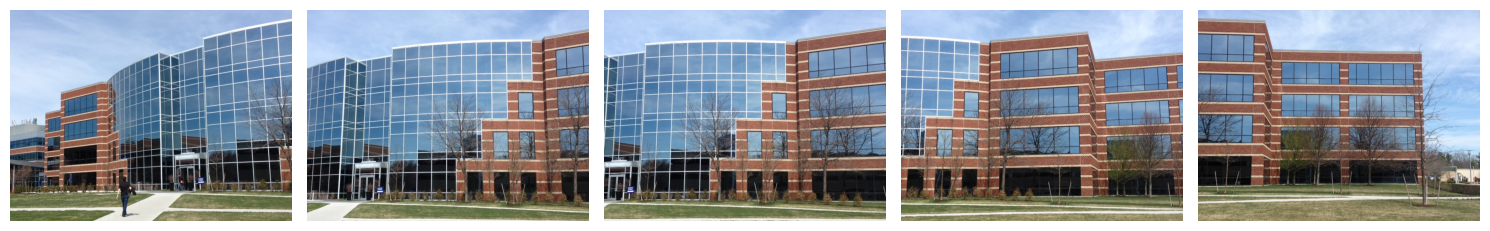

In [69]:
root = './data/building1/'
image_names = sorted(os.listdir(root))

fig, ax = plt.subplots(1, len(image_names), figsize=(15, 8))
ax = ax.ravel()

for img, a in zip(image_names, ax):
    a.imshow(cv.imread(root + img)[..., ::-1])
    a.axis('off')

plt.tight_layout()

In [70]:
res = process_panorama_images([os.path.join(root, img) for img in image_names])

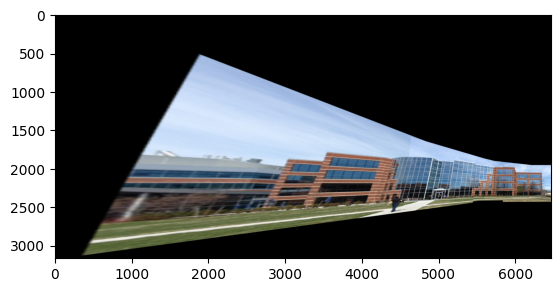

In [71]:
plt.imshow(res)

# Panorama 2

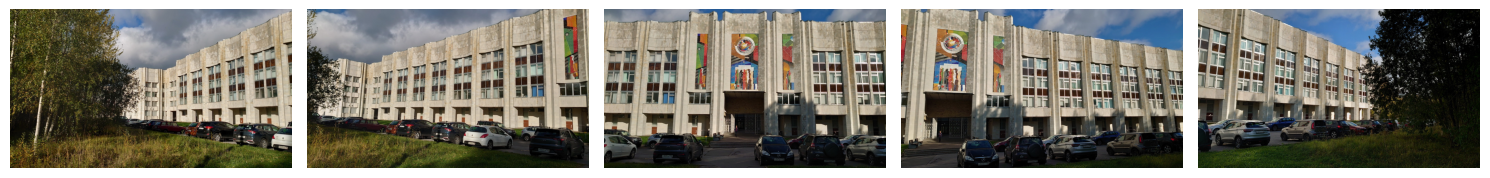

In [90]:
root = './data/building2/'
image_names = sorted(os.listdir(root))[::-1]

fig, ax = plt.subplots(1, len(image_names), figsize=(15, 8))
ax = ax.ravel()

for img, a in zip(image_names, ax):
    a.imshow(cv.imread(root + img)[..., ::-1])
    a.axis('off')

plt.tight_layout()

In [91]:
res = process_panorama_images([os.path.join(root, img) for img in image_names])

first_nonzero_y = res.nonzero()[0].min()
last_nonzero_y = res.nonzero()[0].max()

res = res[first_nonzero_y:last_nonzero_y, ...]

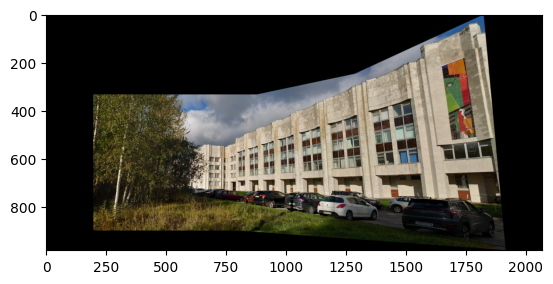

In [92]:
plt.imshow(res)

# Panorama 3

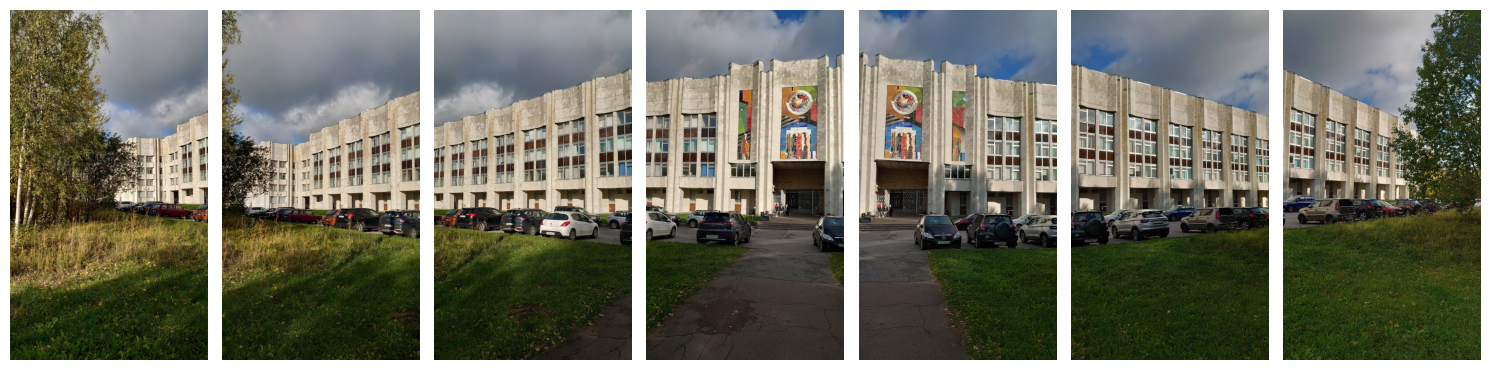

In [94]:
root = './data/building3/'
image_names = sorted(os.listdir(root))[::-1]

fig, ax = plt.subplots(1, len(image_names), figsize=(15, 8))
ax = ax.ravel()

for img, a in zip(image_names, ax):
    a.imshow(cv.imread(root + img)[..., ::-1])
    a.axis('off')

plt.tight_layout()

In [97]:
res = process_panorama_images([os.path.join(root, img) for img in image_names])

first_nonzero_y = res.nonzero()[0].min()
last_nonzero_y = res.nonzero()[0].max()

first_nonzero_x = res.nonzero()[1].min()
last_nonzero_x = res.nonzero()[1].max()

res = res[first_nonzero_y:last_nonzero_y, first_nonzero_x:last_nonzero_x]

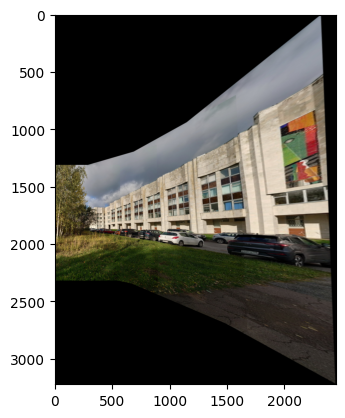

In [98]:
plt.imshow(res)